In [40]:
# Importing Packages
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
import pathlib
dataset_path = "/kaggle/working/train"
train_data_dir = pathlib.Path(dataset_path + "/images")
test_data_dir = pathlib.Path("/kaggle/working/test/images")

train_files = glob.glob(r"" + dataset_path + "/images/*.png")
train_files = list(filter(lambda x: "post" in x, train_files))
train_files = random.sample(train_files, 1500)
train_datasize = len(train_files)
print("Training data:", train_datasize)

test_files = glob.glob(r"" + "/kaggle/working/test/images/*.png")
test_files = list(filter(lambda x: "post" in x, test_files))
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("Test data:", test_datasize)


Training data: 1500
Test data: 500


In [16]:
images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()

1024
1024


In [17]:
img_height = 1024
img_width = 1024
class_names = np.array(sorted(['volcano', 'flooding', 'earthquake', 'fire', 'wind', 'tsunami']))
print(class_names)

['earthquake' 'fire' 'flooding' 'tsunami' 'volcano' 'wind']


In [19]:
def get_label(file_path, type):
    parts = file_path.split('/')
    path = dataset_path + '/labels/'
    if type == "test":
        path = '/kaggle/working/test/labels/'
    f = open(path + parts[-1].split('.')[0] + '.json')
    data = json.load(f)
    disaster_type = data['metadata']['disaster_type']
    f.close()

    label = disaster_type == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot

def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [20]:
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img = PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("Train")
print(train_X.shape)
print(train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img = PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("Test")
print(test_X.shape)
print(test_Y.shape)

Train
(1500, 1024, 1024, 3)
(1500, 6)
Test
(500, 1024, 1024, 3)
(500, 6)


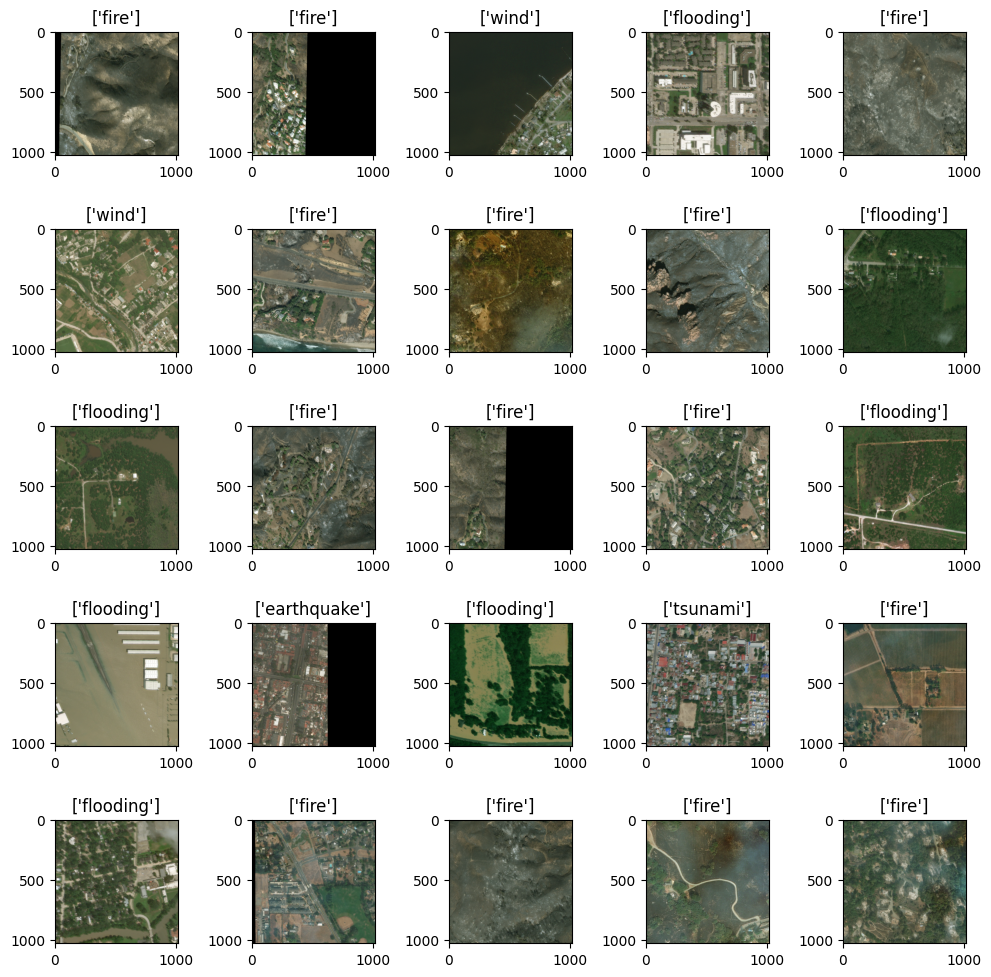

In [22]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    choice = random.randint(0, train_datasize - 1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()

In [24]:
# Load the DenseNet121 model, exclude the top layers (pre-trained on ImageNet)
base_model = DenseNet121(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the base model

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [25]:
model = models.Sequential([
    layers.Input(shape=(1024, 1024, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 32, 32, 1024)        │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,174,086 (27.37 MB)

 Trainable params: 134,278 (524.52 KB)

 Non-trainable params: 7,039,808 (26.85 MB)

In [29]:
# Define the maximum number of epochs
max_epochs = 50
batch_size = 16

# Create an EarlyStopping callback with patience
early_stopping = EarlyStopping(
    monitor='val_loss',# Metric to monitor
    patience = 5,
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model with EarlyStopping
history = model.fit(
    train_X, train_Y,
    validation_data=(test_X, test_Y),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]  # Pass the callback
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.2407 - loss: 4.7717 - val_accuracy: 0.6900 - val_loss: 3.2913
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.4723 - loss: 3.5573 - val_accuracy: 0.8000 - val_loss: 2.6990
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.5897 - loss: 3.1491 - val_accuracy: 0.8160 - val_loss: 2.3964
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6276 - loss: 2.8620 - val_accuracy: 0.8380 - val_loss: 2.1824
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6862 - loss: 2.6005 - val_accuracy: 0.8560 - val_loss: 2.0285
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7452 - loss: 2.4134 - val_accuracy: 0.8820 - val_loss: 1.9086
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7490 - loss: 2.2176 - val_accuracy: 0.8940 - val_loss: 1.8160
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7637 - loss: 2.1820 - val_accuracy: 0.9040 - v

In [30]:
# Model Evaluation and Metrics Calculation
#y_pred = model.predict(test_X)
#y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(test_Y, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step


In [31]:
# Calculate accuracy
#accuracy = accuracy_score(y_true_classes, y_pred_classes)
#print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9700


In [33]:
# Evaluate model on test data to get loss and accuracy
print("\nEvaluating model on test data:\n")
loss, accuracy = model.evaluate(test_X, test_Y, verbose=0)

# Print loss and accuracy
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Test Accuracy: 0.9700
Test Loss: 0.7222


In [36]:
# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

  earthquake       0.94      1.00      0.97        17
        fire       1.00      0.98      0.99       206
    flooding       0.94      0.99      0.96       166
     tsunami       1.00      0.89      0.94        19
     volcano       0.00      0.00      0.00         2
        wind       0.96      0.94      0.95        90

    accuracy                           0.97       500
   macro avg       0.81      0.80      0.80       500
weighted avg       0.97      0.97      0.97       500



In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 17   0   0   0   0   0]
 [  1 202   2   0   0   1]
 [  0   0 164   0   0   2]
 [  0   0   1  17   0   1]
 [  0   0   2   0   0   0]
 [  0   0   5   0   0  85]]


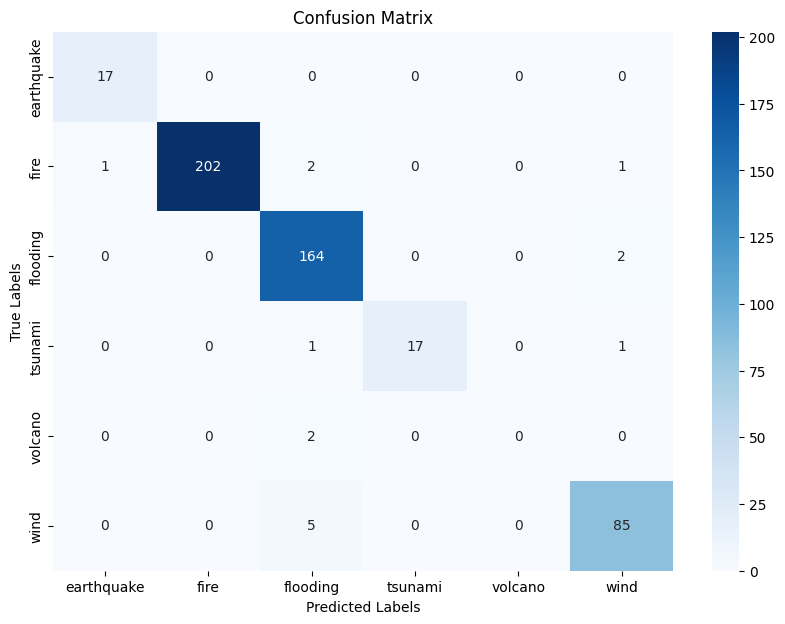

In [41]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

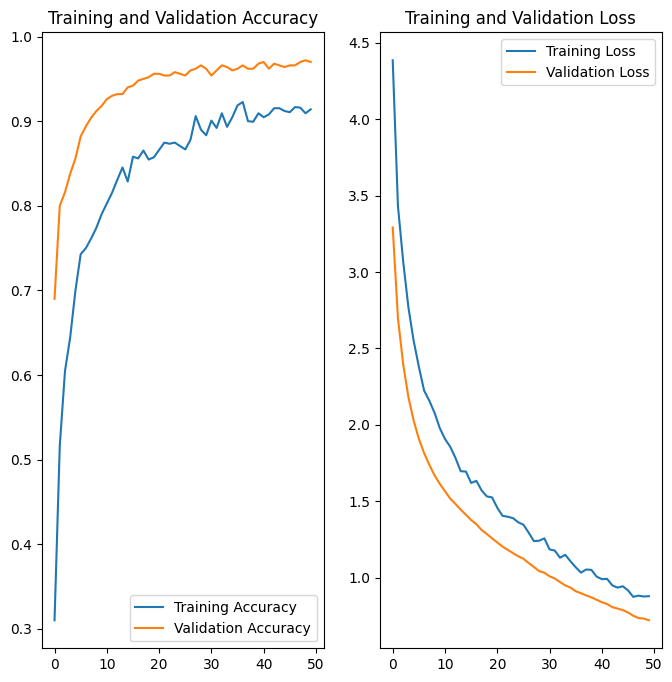

In [43]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
# Save as a Keras model (Native Keras format)
model.save('Multi_Class_Disaster_Classification_Model.keras')  

# Save as a .h5 file (HDF5 format), explicitly including the optimizer
model.save('Multi_Class_Disaster_Classification_Model.h5', include_optimizer=True)  

# Export as TensorFlow SavedModel format (directory format)
model.export('Multi_Class_Disaster_Classification_Model')

Saved artifact at 'Multi_Class_Disaster_Classification_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name='keras_tensor_427')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138691279739664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138692360601296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690337971136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690338244560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690333457424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138683930154912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138683930157728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138683930155440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138683930156144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138683930161248: TensorSpec(shape=(), dtype=tf.resour

In [47]:
# Gradio Interface for Inference
def disaster_classification(img):
    img_resized = np.array(Image.fromarray(img).resize((img_height, img_width)))
    image = np.zeros((1, img_height, img_width, 3), dtype=np.uint8)
    image[0] = img_resized
    prediction = model.predict(image).tolist()[0]
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

iface = gr.Interface(
    fn=disaster_classification,
    inputs=gr.Image(image_mode='RGB', type='numpy'),
    outputs=gr.Label()
)

iface.launch(share=True, show_error=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://ffafb92504bc62de41.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ffafb92504bc62de41.gradio.live
